# Variational Bayesian Last Layers for Bayesian Optimization

* Contributors: brunzema
* Last updated: Feb 13, 2025
* BoTorch version: 0.9.6(dev), commit hash: dccda59d8ef51d8074de82fdb5614bad2db0ee96 UPDATE!

In this notebook, we will demonstrate how to use variational Bayesian last layers (VBLLs) for Bayesian optimization [1]. 

[1] P. Brunzema, M. Jordahn, J. Willes, S. Trimpe, J. Snoek, J. Harrison. Bayesian Optimization via Continual Variational Last Layer Training. International Conference on Learning Representations (ICLR), 2025.

[2] J. Harrison, J. Willes, J. Snoek. Variational Bayesian Last Layers. International Conference on Learning Representations (ICLR), 2024.

# Introduction to the VBLL Model

Linear model
$$
    y = \mathbf{w}^\top \phi_{\theta} (\mathbf{x}) + \varepsilon
$$
where $\varepsilon \sim \mathcal{N}(0, \sigma^2)$
Variational Bayesian last layer models [2] use a variational posterior distribution on the weights as $\mathbf{w} \sim q(\mathbf{w})$ with $q(\mathbf{w}) = \mathcal{N}(\bar{\mathbf{w}}, S)$ where $\bar{\mathbf{w}}$ is the mean and $S$ the full covariance of a multivariate normal distribution.
Through conjugany, we yield the posterior predictive 
$$
    p(y \mid \mathbf{x}, \mathcal{D}_T, \theta) = \mathcal{N} \big( \bar{\mathbf{w}}_T^\top \phi_{\theta}(\mathbf{x}), \, \phi_{\theta}(\mathbf{x})^\top S_T \phi_{\theta}(\mathbf{x}) + \sigma^{2} \big).
$$

## The VBLL Model on Toy Data

Before using the VBLL model in the context of Bayesian Optimization (BO), let's see how the interface of the model looks. The current implementation allows for passing a full backbone to the model (which could be anything). If no backbone is provided, a standard MLP is created. For training, there are also various options to include recursive updates on the last layer to speed up optimzation [1] but in the following, we will not go into detail. See the docstring of `model.fit` for the different options.

Below, we use the model in a 1D regression example. We can see that only...


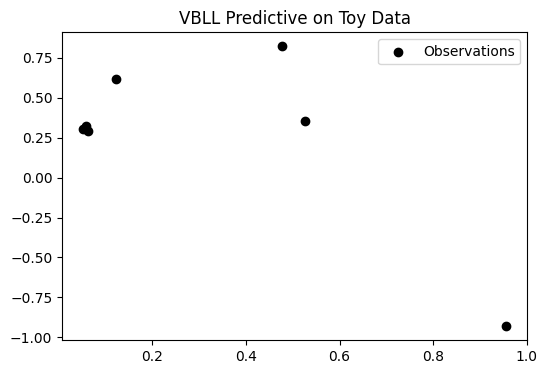

In [23]:
import matplotlib.pyplot as plt
import torch
from botorch_community.models.vblls import VBLLModel

torch.set_default_dtype(torch.float64)
torch.manual_seed(42)


def objective(x, noise=True):
    out = torch.sin(x * 5)
    if noise:
        out += 0.1 * torch.randn_like(x)
    return out


X = torch.rand(7, 1)
Y = objective(X)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.set_title("VBLL Predictive on Toy Data")
ax.scatter(X, Y, c="k", label="Observations")
ax.legend()
plt.show()

In [24]:
model = VBLLModel(
    in_features=1,
    hidden_features=50,
    num_layers=3,
    out_features=1,
)

# lets print the model, we can see the MLP backbone and the VBLL regression head
print(model)

# fit the model on the data -- it is also possible to specify the optimizer throught `optimizer_settings` (see docstring)
model.fit(X, Y)

VBLLNetwork(
  (activation): ELU(alpha=1.0)
  (backbone): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ELU(alpha=1.0)
    (2): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ELU(alpha=1.0)
    )
    (3): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ELU(alpha=1.0)
    )
    (4): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ELU(alpha=1.0)
    )
  )
  (head): Regression()
)
Early stopping at epoch  6332  with loss  1.0455903860560616


Now we can use the model in the same way as a Gaussian process. Note, below is the exact same code as one would use with a GPyTorch model!

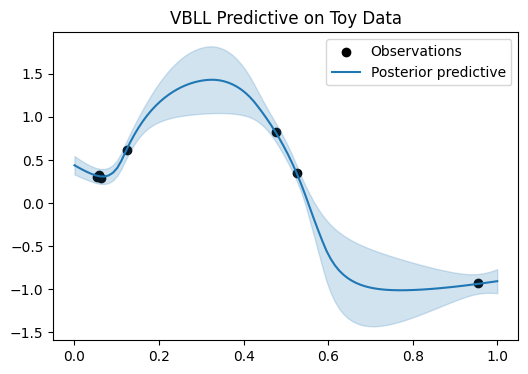

In [25]:
test_X = torch.linspace(0, 1, 100)
with torch.no_grad():
    posterior = model.posterior(test_X.view(-1, 1))
mean, std = posterior.mean.squeeze(), posterior.variance.sqrt().squeeze()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.set_title("VBLL Predictive on Toy Data")
ax.scatter(X, Y, c="k", label="Observations")
ax.plot(test_X, mean, label="Posterior predictive", color="tab:blue")
ax.fill_between(test_X, mean - 2 * std, mean + 2 * std, alpha=0.2, color="tab:blue")
ax.legend()
plt.show()

## Thompson sampling with VBLLs

VBLLs yield a Gaussian predictive distribution, and thus most acquisition functions that are straightforward to compute for Gaussian Processes (GPs) are also straightforward for VBLLs.  
Moreover, parametric VBLLs are especially well-suited for Thompson sampling.  

For a Thompson sample, we simply sample from the variational posterior of $\mathbf{w}$ at iteration $t$ and then construct a sample from the predictive $\hat{f}$ as a generalized linear model:

\begin{aligned}
    &\textcircled{1} \quad \hat{\mathbf{w}} \sim q(\mathbf{w})  \\
    &\textcircled{2} \quad \hat{f} (\mathbf{x}) \coloneqq \hat{\mathbf{w}}^\top \phi_{\theta} (\mathbf{x}).
\end{aligned}

We can directly leverage this in BO to choose the next query location as $\mathbf{x}_{t+1} = \arg\max_{\mathbf{x} \in \mathcal{X}} \hat{f} (\mathbf{x})$. Compared to other standard implementation, we can numerically optimize the sample path as we can simply calculate gradients of the sample.




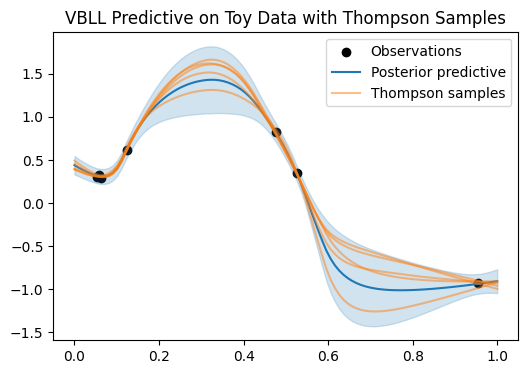

In [26]:
def plot_model(model, x, y, new_data=None, show_opjective=False):
    x_test = torch.linspace(0, 1, 100)
    with torch.no_grad():
        posterior = model.posterior(x_test.view(-1, 1))
    mean, std = posterior.mean.squeeze(), posterior.variance.sqrt().squeeze()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    ax.set_title("VBLL Predictive on Toy Data with Thompson Samples")
    ax.scatter(x, y, c="k", label="Observations")

    if new_data is not None:
        x_new, y_new = new_data
        ax.scatter(x_new, y_new, c="r", label="New observations")

    if show_opjective:
        ax.plot(x_test, objective(x_test, noise=False), label="Objective", color="k")

    ax.plot(x_test, mean, label="Posterior predictive", color="tab:blue")

    # Posterior samples
    with torch.no_grad():
        for i in range(5):
            ts_sample = model.sample()  # a sample is essentially a standard MLP (one can also generate multiple samples, see function)
            ts_mean = ts_sample(x_test.view(-1, 1)).squeeze()
            ax.plot(
                x_test,
                ts_mean,
                color="tab:orange",
                alpha=0.5,
                label="Thompson samples" if i == 0 else None,
            )

    ax.fill_between(x_test, mean - 2 * std, mean + 2 * std, alpha=0.2, color="tab:blue")
    ax.legend()
    plt.show()


plot_model(model, X, Y)

# Bayesian optimization with VBLLs

Iteration 0) 	 Best Value: 0.3324226803440067
Early stopping at epoch  3499  with loss  8.285541518367179


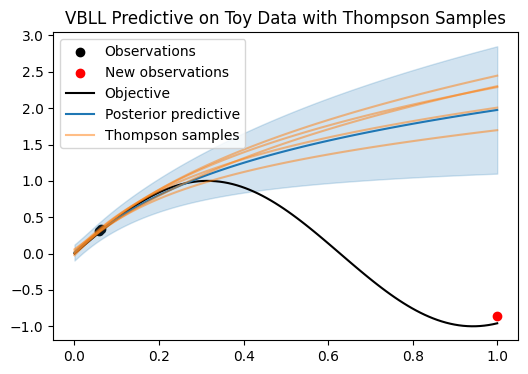

Iteration 1) 	 Best Value: 0.3324226803440067
Early stopping at epoch  7389  with loss  5.121181297492753


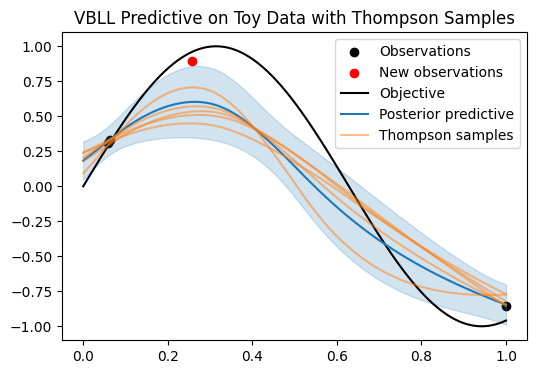

Iteration 2) 	 Best Value: 0.8926797760383713
Early stopping at epoch  6599  with loss  3.4750899036796015


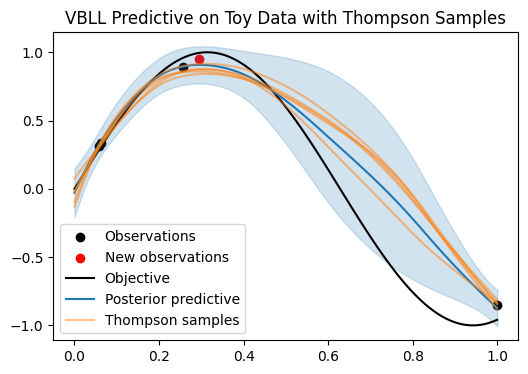

Iteration 3) 	 Best Value: 0.9538915741567119
Early stopping at epoch  10000  with loss  2.4829863769911618


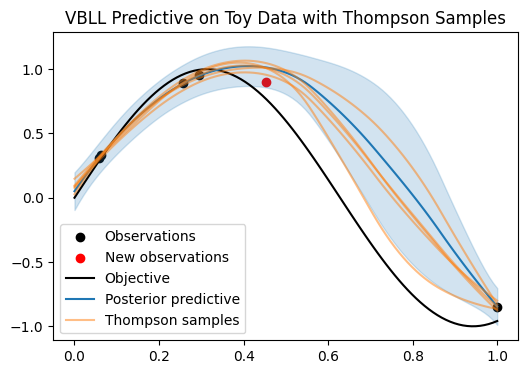

Iteration 4) 	 Best Value: 0.9538915741567119
Early stopping at epoch  7999  with loss  1.7124188780350311


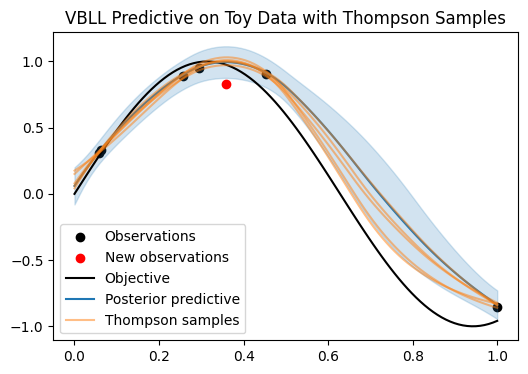

Iteration 5) 	 Best Value: 0.9538915741567119
Early stopping at epoch  8152  with loss  1.155492580065923


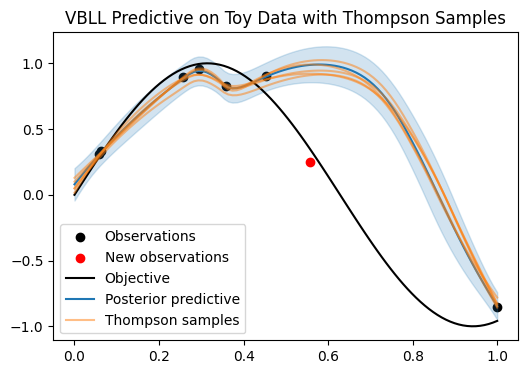

Iteration 6) 	 Best Value: 0.9538915741567119
Early stopping at epoch  6525  with loss  0.7314200558434392


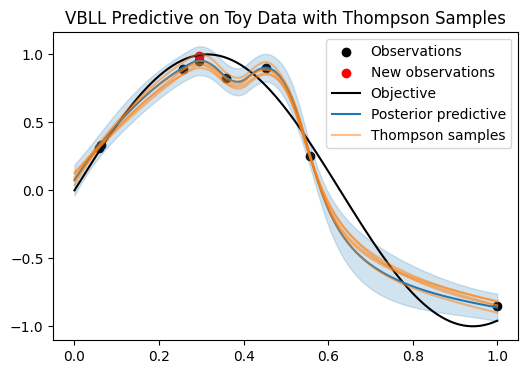

Iteration 7) 	 Best Value: 0.9844725089729858
Early stopping at epoch  6479  with loss  0.6798152420784924


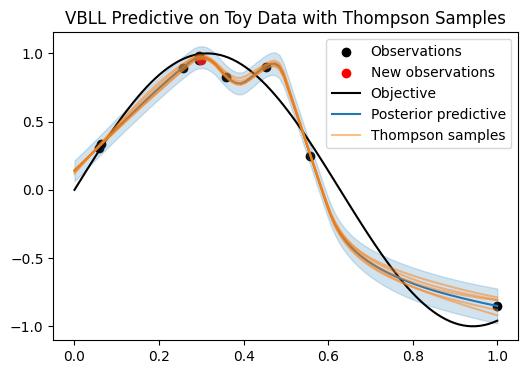

Iteration 8) 	 Best Value: 0.9844725089729858
Early stopping at epoch  6802  with loss  0.2123743140449812


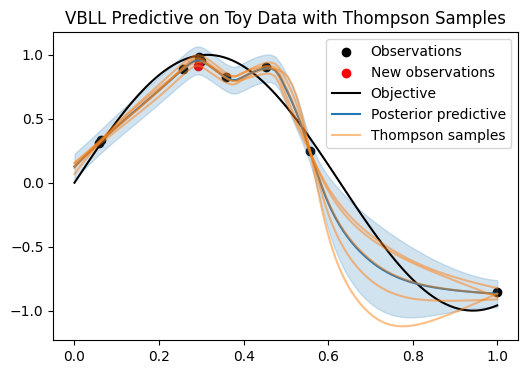

Iteration 9) 	 Best Value: 0.9844725089729858
Early stopping at epoch  1684  with loss  5628.575479705238


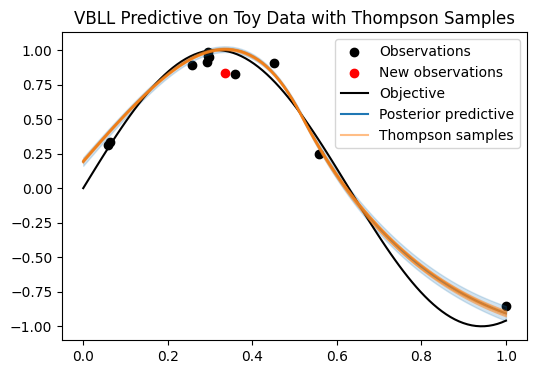

Iteration 10) 	 Best Value: 0.9844725089729858
Early stopping at epoch  5111  with loss  0.04339227997413797


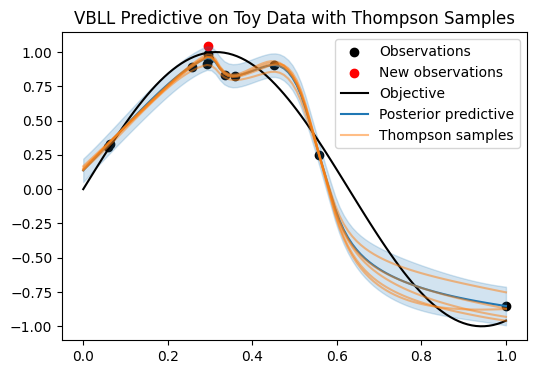

Iteration 11) 	 Best Value: 1.0413360979829451
Early stopping at epoch  9677  with loss  -0.07003120007894692


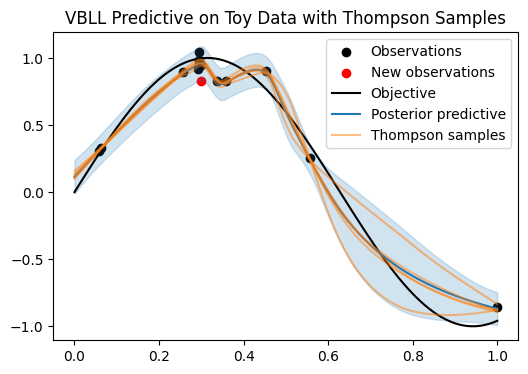

Iteration 12) 	 Best Value: 1.0413360979829451
Early stopping at epoch  10000  with loss  0.11074134634137334


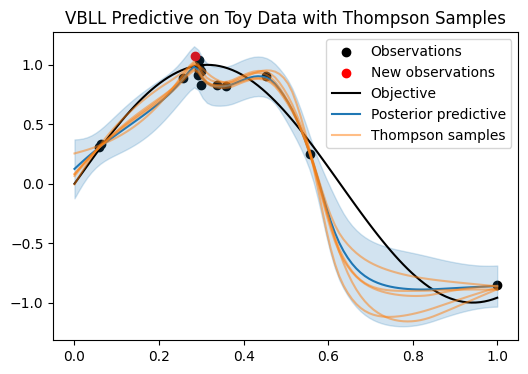

Iteration 13) 	 Best Value: 1.0779572447975334
Early stopping at epoch  4994  with loss  -0.022944017572688047


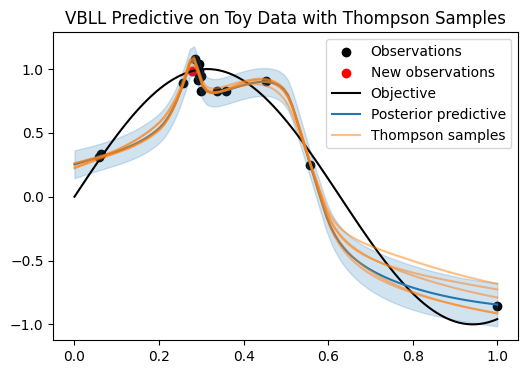

Iteration 14) 	 Best Value: 1.0779572447975334
Early stopping at epoch  5647  with loss  -0.04839443149730904


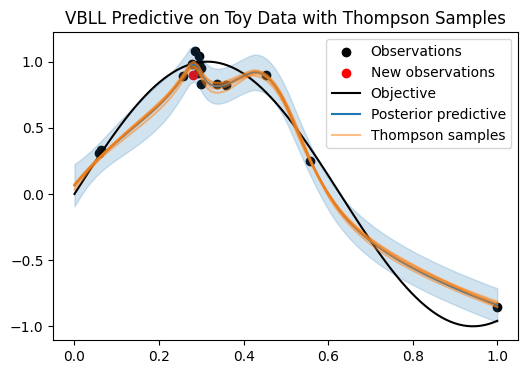

Iteration 15) 	 Best Value: 1.0779572447975334
Early stopping at epoch  6767  with loss  -0.0955379474696385


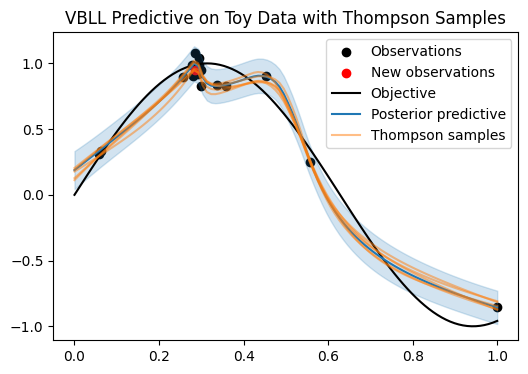

Iteration 16) 	 Best Value: 1.0779572447975334
Early stopping at epoch  5970  with loss  -0.22222854543641746


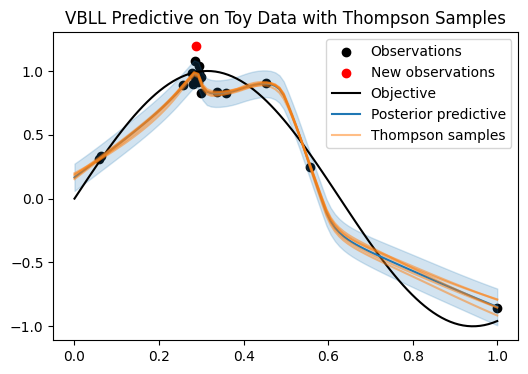

Iteration 17) 	 Best Value: 1.1935042208215094
Early stopping at epoch  9089  with loss  -0.15552467146204463


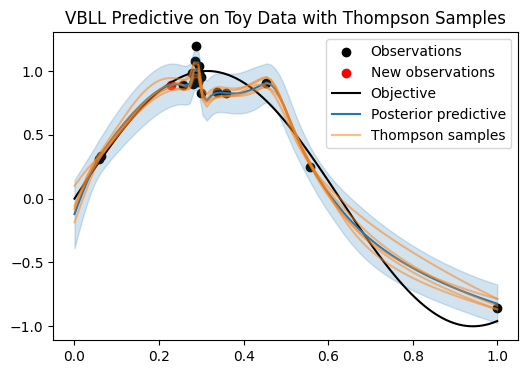

Iteration 18) 	 Best Value: 1.1935042208215094
Early stopping at epoch  6128  with loss  -0.11396026729265785


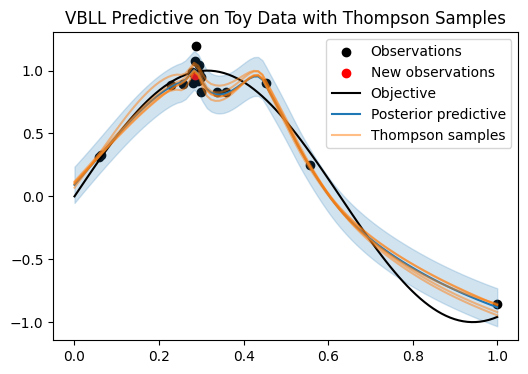

Iteration 19) 	 Best Value: 1.1935042208215094
Early stopping at epoch  3919  with loss  -0.06498622307422375


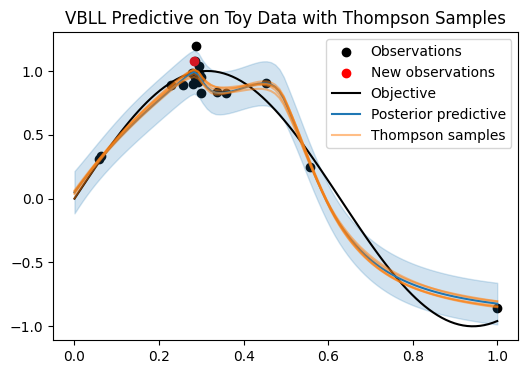

In [27]:
from botorch_community.acquisition.bll_thompson_sampling import BLLMaxPosteriorSampling

batch_size = 1

torch.manual_seed(42)
X_bo = torch.rand(2, 1)
Y_bo = objective(X_bo)

# lets define the optimizer settings
optimizer_settings = {
    "num_epochs": 10_000,  # number of epochs
    "freeze_backbone": False,  # whether to freeze the backbone / features during training
    "patience": 100,  # patience for early stopping (if no improvement for `patience` epochs, stop training)
    "batch_size": 32,  # mini-batch size
    "optimizer": torch.optim.AdamW,  # optimizer
    "wd": 1e-4,  # weight decay
    "lr": 1e-3,  # learning rate
    "clip_val": 1.0,  # gradient clipping value
}

for iteration in range(20):
    print(f"Iteration {iteration}) \t Best Value: {Y_bo.max().item()}")

    # initialize the model
    model = VBLLModel(
        in_features=1,
        hidden_features=50,
        num_layers=3,
        out_features=1,
    )
    model.fit(X_bo, Y_bo, optimization_settings=optimizer_settings)

    # Thompson sampling as acquisition function
    thompson_sampling = BLLMaxPosteriorSampling(
        model=model,
        num_restarts=10,
    )
    X_next = thompson_sampling(num_samples=batch_size)

    # evaluate the objective
    Y_next = objective(X_next)

    # plot the model, the thompson samples and the objective
    plot_model(model, X_bo, Y_bo, new_data=(X_next, Y_next), show_opjective=True)

    # update the data
    X_bo = torch.cat([X_bo, X_next])
    Y_bo = torch.cat([Y_bo, Y_next])